# Explaining Outcomes with Wordclouds

TODO

In [2]:
import numpy as np
from tensorflow import keras
import slise
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]

## Dataset

In [111]:
(l_train, y_train), (l_test, y_test) = keras.datasets.imdb.load_data(num_words=1000, oov_char=0)
word_index = keras.datasets.imdb.get_word_index()
words = list(range(999))
for w in word_index:
    i = word_index[w]
    if i < 1000:
        words[i-1] = w

# Count occurances and normalise based on most frequent
x_train = np.zeros((len(y_train), 1001))
for i, l in enumerate(l_train):
    ind, cnt = np.unique(l, return_counts=True)
    if ind[0] == 0:
        m = np.max(cnt[1:]) + 0.1
    else:
        m = np.max(cnt) + 0.1
    x_train[i, ind] = cnt / m
x_train = x_train[:, 1:-1]
x_test = np.zeros((len(y_test), 1001))
for i, l in enumerate(l_test):
    ind, cnt = np.unique(l, return_counts=True)
    if ind[0] == 0:
        m = np.max(cnt[1:]) + 0.1
    else:
        m = np.max(cnt) + 0.1
    x_test[i, ind] = cnt / m
x_test = x_test[:, 1:-1]

# Label Smoothing
y_train = y_train * 0.8 + 0.1

# Remove short words
mask = [i for i, w in enumerate(words) if len(w) > 2]
x_train = x_train[:, mask]
x_test = x_test[:, mask]
words = [w for w in words if len(w) > 2]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\anton\miniconda3\envs\slise\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\anton\miniconda3\envs\slise\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) i

## Model

In [114]:
model = keras.Sequential(
    [
        keras.Input(shape=x_train.shape[1]),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               121344    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [115]:
# Train the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=256, epochs=8, validation_split=0.1)

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/8
88/88 [==============================] - 0s 5ms/step - loss: 0.6402 - accuracy: 0.0000e+00 - val_loss: 0.6673 - val_accuracy: 0.0000e+00
Epoch 2/8
88/88 [==============================] - 0s 4ms/step - loss: 0.5151 - accuracy: 0.0000e+00 - val_loss: 0.6219 - val_accuracy: 0.0000e+00
Epoch 3/8
88/88 [==============================] - 0s 4ms/step - loss: 0.4823 - accuracy: 0.0000e+00 - val_loss: 0.5760 - val_accuracy: 0.0000e+00
Epoch 4/8
88/88 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.0000e+00 - val_loss: 0.5415 - val_accuracy: 0.0000e+00
Epoch 5/8
88/88 [==============================] - 0s 3ms/step - loss: 0.4423 - accuracy: 0.0000e+00 - val_loss: 0.5148 - val_accuracy: 0.0000e+00
Epoch 6/8
88/88 [==============================] - 0s 3ms/step - loss: 0.4257 - accuracy: 0.0000e+00 - val_loss: 0.5000 - val_accuracy: 0.0000e+00
Epoch 7/8
88/88 [==============================] - 0s 3ms/step - loss: 0.4067 - accuracy: 0.0000e+00 - val_loss: 0.510

## Explanation

In [142]:
item = 6
p_test = model.predict(x_test).ravel()
explanation = slise.explain(x_test[:, x_test[item] > 0], p_test, 1.5, item, lambda1=12.5, logit=True)
print("Neighbourhood size:", explanation.subset().mean())

Neighbourhood size: 0.63356


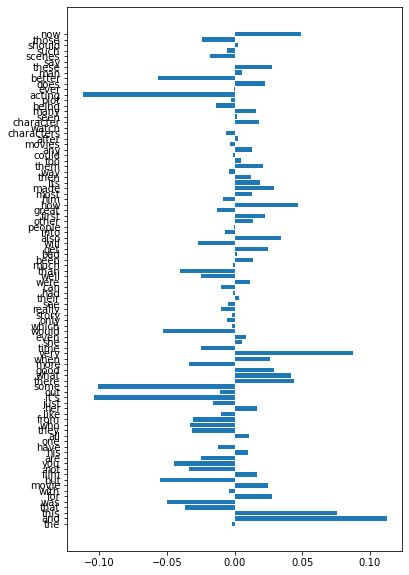

In [143]:
impact = explanation.get_impact()
expl = {w:i for i, w in zip(impact[1:], words) if i != 0}
plt.figure(figsize=(6, 10))
plt.barh(list(expl.keys()), expl.values())
plt.show()


C:\Users\anton\miniconda3\envs\slise\lib\site-packages\slise\plot.py:335: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


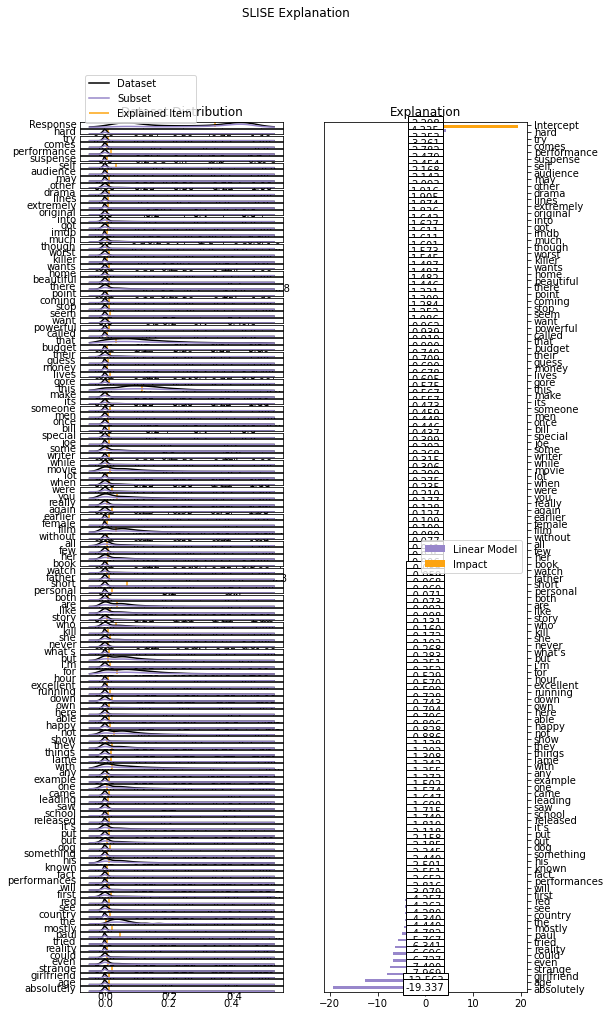

In [136]:
variables = [w for x, w in zip(x_test[item], words) if x > 0]
explanation.plot_dist(variables=variables, fig=plt.figure(figsize=(8, 16)))
plt.show()

In [137]:
explanation.subset().mean()

0.3724